Vision Transformer


In [41]:
import torchvision
import torch

from torch import nn
from torch.overrides import is_tensor_method_or_property
from torch.utils.data import DataLoader
from torchvision import transforms,datasets

Preparing Transforms

In [40]:
train_transform=transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((32, 32),antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0),
                 ratio=(0.75, 1.3333333333333333),
                 interpolation=2,antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
test_transform=transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((32, 32),antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

)

Loading Data Using ImageFolder from PyTorch

In [57]:
train_dataset=datasets.ImageFolder(root="./data/Training",transform=train_transform)

In [58]:
test_dataset=datasets.ImageFolder(root="./data/Testing",transform=test_transform)

Label Classes

In [161]:
classes=train_dataset.classes

In [162]:
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [61]:
len(test_dataset)

1311

In [62]:
train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=32,shuffle=True)

In [110]:
device="cuda"

In [111]:
class Config:
    patch_size=4
    hidden_size=48
    num_hidden_layers=4
    num_attention_heads=4
    intermediate_size= 4 * 48
    image_size=32
    num_classes=4
    num_channels=3
config=Config()

We divide our image into 64 patches ,

In [112]:

class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.projection = nn.Conv2d(config.num_channels,
                                    config.hidden_size,
                                    kernel_size=config.patch_size,
                                    stride=config.patch_size)
    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x

In [114]:
patch_embed = PatchEmbeddings(config)
img=torch.randn(1,3,32,32)
out=patch_embed(img)
print(out.shape)
#Final shape -> 1 image,64 patches, each path 48-dim vector)

torch.Size([1, 64, 48])


Embedding functions to apply on the test/train batches from dataloader

In [115]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings=PatchEmbeddings(config)
        self.cls_token=nn.Parameter(torch.randn(1,1,config.hidden_size))
        num_patches =(config.image_size //config.patch_size)**2
        self.position_embeddings=\
        nn.Parameter(torch.randn(1,num_patches+1,config.hidden_size))
    def forward(self, x):
        x=self.patch_embeddings(x)
        batch_size, _, _, = x.size()
        cls_tokens=self.cls_token.expand(batch_size, -1, -1)
        x=torch.cat((cls_tokens, x), dim=1)
        x=x+self.position_embeddings
        return x



In [116]:
embed=Embeddings(config)
# create a hypothetical image
img=torch.randn((1,3,32,32))
# pass a batch of one image through the class
out=embed(img)
# the shapes of the output
print(out.shape)
# the shapes of the positional encoding
print(embed.position_embeddings.shape)

torch.Size([1, 65, 48])
torch.Size([1, 65, 48])


Multi Head Attention Mechanism

In [117]:
import math

In [118]:
class AttentionHead(nn.Module):
    def __init__(self, hidden_size, attention_head_size, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)
    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(\
                self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)

In [119]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = \
        self.hidden_size // self.num_attention_heads
        self.all_head_size = \
        self.num_attention_heads * self.attention_head_size
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size)
            self.heads.append(head)
        self.output_projection = nn.Linear(self.all_head_size,\
                                           self.hidden_size)
    def forward(self, x, output_attentions=False):
        attention_outputs = [head(x) for head in self.heads]
        attention_output = torch.cat([attention_output for attention_output,
                                      _ in attention_outputs], dim=-1)
        attention_output = self.output_projection(attention_output)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _,
                           attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)

Feed Forward Networkk

In [120]:

from torch.nn import GELU


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config.hidden_size,
                                 config.intermediate_size)
        self.activation = GELU()
        self.dense_2 = nn.Linear(config.intermediate_size,
                                 config.hidden_size)
    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        return x

Encoder Block

In [121]:
#Residual Connections-> Add&Norm block in the Transformer

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config.hidden_size)
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config.hidden_size)
    def forward(self, x, output_attentions=False):
        attention_output, attention_probs = \
        self.attention(self.layernorm_1(x),
                       output_attentions=output_attentions)
        x = x + attention_output
        mlp_output = self.mlp(self.layernorm_2(x))
        x = x + mlp_output
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)

In [85]:
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(config.num_hidden_layers):
            block = Block(config)
            self.blocks.append(block)
    def forward(self, x, output_attentions=False):
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x,
               output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)

Transformer

In [122]:
class ViTForClassfication(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config.image_size
        self.hidden_size = config.hidden_size
        self.num_classes = config.num_classes
        self.embedding = Embeddings(config)
        self.encoder = Encoder(config)
        self.classifier = nn.Linear(self.hidden_size,
                                    self.num_classes)
        self.apply(self._init_weights)
    def forward(self, x, output_attentions=False):
        embedding_output = self.embedding(x)
        encoder_output, all_attentions = self.encoder(\
          embedding_output,output_attentions=output_attentions)
        logits = self.classifier(encoder_output[:, 0, :])
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,std=0.02,).to(module.position_embeddings.dtype)
            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,std=0.02,).to(module.cls_token.dtype)

In [135]:
model = ViTForClassfication(config).to(device)
model.to(device)

ViTForClassfication(
  (embedding): Embeddings(
    (patch_embeddings): PatchEmbeddings(
      (projection): Conv2d(3, 48, kernel_size=(4, 4), stride=(4, 4))
    )
  )
  (encoder): Encoder(
    (blocks): ModuleList(
      (0-3): 4 x Block(
        (attention): MultiHeadAttention(
          (heads): ModuleList(
            (0-3): 4 x AttentionHead(
              (query): Linear(in_features=48, out_features=12, bias=True)
              (key): Linear(in_features=48, out_features=12, bias=True)
              (value): Linear(in_features=48, out_features=12, bias=True)
            )
          )
          (output_projection): Linear(in_features=48, out_features=48, bias=True)
        )
        (layernorm_1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (dense_1): Linear(in_features=48, out_features=192, bias=True)
          (activation): GELU(approximate='none')
          (dense_2): Linear(in_features=192, out_features=48, bias=True)
        )
        (la

Defining Optimizer

In [136]:
optimizer = torch.optim.AdamW(model.parameters(),
                lr=0.01, weight_decay=1e-2)

Loss Function

In [137]:
loss_fn = nn.CrossEntropyLoss()

In [138]:

scaler = torch.amp.GradScaler()

Training Process

'cuda'

In [139]:
class EarlyStop:
    def __init__(self, patience=3):
        self.patience = patience
        self.steps = 0
        self.min_loss = float('inf')
    def stop(self, loss):
        if loss < self.min_loss:
            self.min_loss = loss
            self.steps = 0
            to_save = True
        elif loss >= self.min_loss:
            self.steps += 1
            to_save = False
        if self.steps >= self.patience:
            to_stop = True
        else:
            to_stop = False
        return to_save, to_stop

stopper=EarlyStop()

In [140]:
def train_batch(batch):
    batch = [t.to(device) for t in batch]
    images, labels = batch
    with torch.amp.autocast(device):
        loss = loss_fn(model(images)[0], labels)
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    return loss.item()*len(images)/len(train_dataloader.dataset)

In [141]:
from tqdm.notebook import tqdm
from pathlib import Path

dir=Path("../files")
dir.mkdir(parents=True, exist_ok=True)

In [142]:
for i in range(100):
    print(f'Epoch {i+1}')
    model.train()
    trainL, testL = 0, 0
    for batch in train_dataloader:
        loss=train_batch(batch)
        trainL+=loss
    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            batch = [t.to(device) for t in batch]
            images, labels = batch
            logits, _ = model(images)
            loss = loss_fn(logits, labels)
            testL+=loss.item()*len(images)/len(test_dataloader.dataset)
    print(f'Train and test losses: {trainL:.4f}, {testL:.4f}')
    to_save, to_stop = stopper.stop(testL)
    if to_save==True:
        torch.save(model.state_dict(), "../files/ViT.pth")
    if to_stop==True:
        break

Epoch 1
Train and test losses: 1.1587, 1.0870
Epoch 2
Train and test losses: 0.9633, 1.0035
Epoch 3
Train and test losses: 0.8818, 0.8981
Epoch 4
Train and test losses: 0.8420, 0.9187
Epoch 5
Train and test losses: 0.8032, 0.9814
Epoch 6
Train and test losses: 0.7700, 0.8968
Epoch 7
Train and test losses: 0.8057, 0.7958
Epoch 8
Train and test losses: 0.6985, 0.8459
Epoch 9
Train and test losses: 0.6837, 0.7079
Epoch 10
Train and test losses: 0.6621, 0.6713
Epoch 11
Train and test losses: 0.6376, 0.7502
Epoch 12
Train and test losses: 0.6231, 0.5984
Epoch 13
Train and test losses: 0.6205, 0.7071
Epoch 14
Train and test losses: 0.5908, 0.6934
Epoch 15
Train and test losses: 0.5954, 0.6570


In [144]:
import  math
import torch.nn.functional as F

model.load_state_dict(torch.load("../files/ViT.pth"))
model.eval()
with torch.inference_mode():
    batch=next(iter(test_dataloader))
    batch = [t.to(device) for t in batch]
    images, labels = batch
    logits, attention_maps = model(images, output_attentions=True)
    predictions = torch.argmax(logits, dim=1).detach().cpu().numpy()

In [159]:
predictions.to("cpu")
print([labels[i] for i in predictions])


[tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')]


In [163]:
print([classes[i] for i in predictions])

['meningioma', 'notumor', 'pituitary', 'pituitary', 'notumor', 'notumor', 'pituitary', 'notumor', 'notumor', 'notumor', 'meningioma', 'pituitary', 'glioma', 'notumor', 'pituitary', 'notumor', 'notumor', 'pituitary', 'pituitary', 'notumor', 'notumor', 'glioma', 'pituitary', 'glioma', 'notumor', 'meningioma', 'notumor', 'pituitary', 'pituitary', 'glioma', 'glioma', 'pituitary']


In [164]:
import matplotlib.pyplot as plt

attention map shape: torch.Size([32, 16, 65, 65])
attention map shape: torch.Size([32, 16, 64])
attention map shape: torch.Size([32, 64])
attention map shape: torch.Size([32, 8, 8])
attention map shape: torch.Size([32, 32, 32])


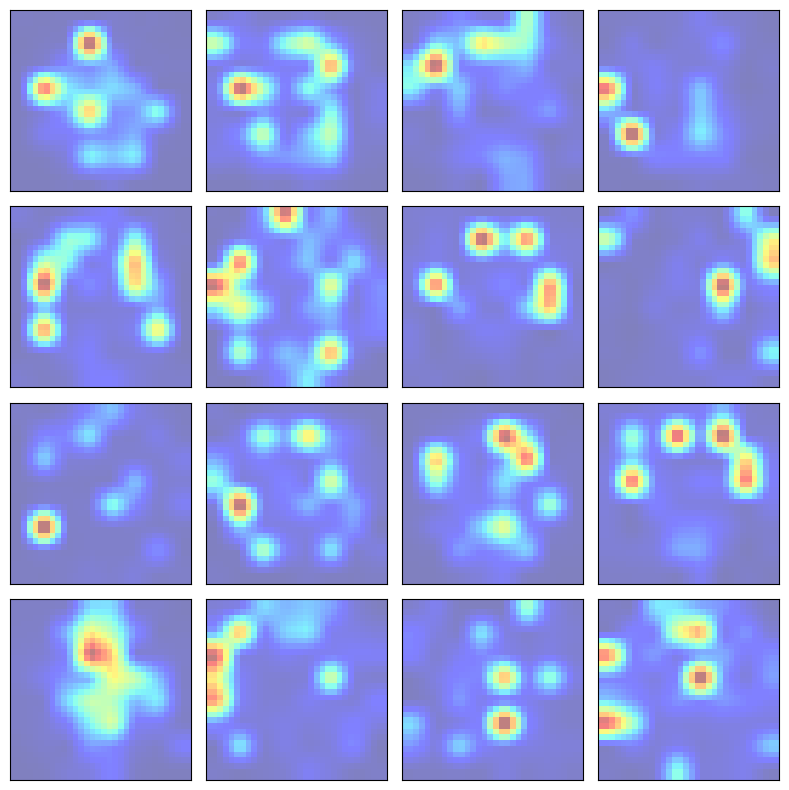

In [165]:
with torch.no_grad():
    attention_maps = torch.cat(attention_maps, dim=1)
    print(f"attention map shape: {attention_maps.shape}")
    attention_maps = attention_maps[:, :, 0, 1:]
    print(f"attention map shape: {attention_maps.shape}")
    attention_maps = attention_maps.mean(dim=1)
    print(f"attention map shape: {attention_maps.shape}")
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    print(f"attention map shape: {attention_maps.shape}")
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32),
                       mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)    #D
    print(f"attention map shape: {attention_maps.shape}")

fig = plt.figure(figsize=(8, 8),dpi=100)
for i in range(16):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(attention_maps[i].cpu(), alpha=0.5, cmap='jet')
plt.tight_layout()
plt.show()

In [166]:
import numpy as np

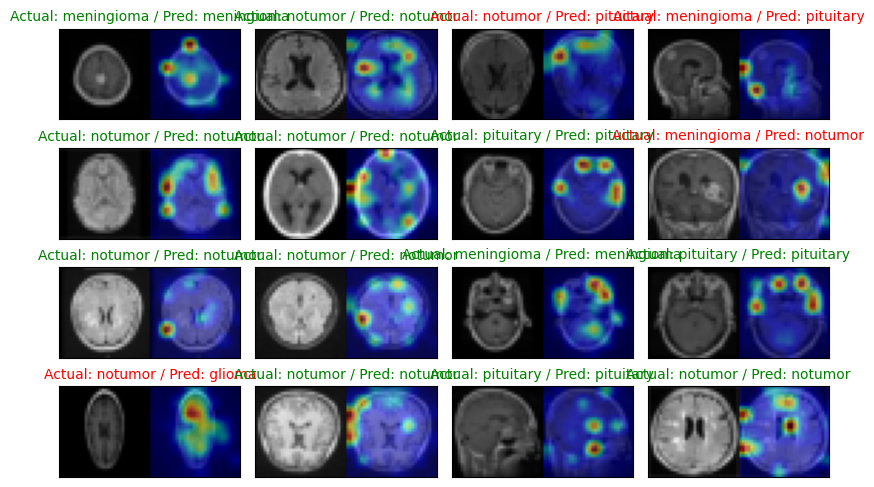

In [168]:
fig = plt.figure(figsize=(8, 5),dpi=100)
mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))],
                      axis=1)
for i in range(16):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    img = np.concatenate((images[i].cpu(), images[i].cpu()),
                         axis=-1)
    ax.imshow(img.transpose(1,2,0)/2+0.5)
    extended_attention_map = np.concatenate((np.zeros((32, 32)),
                                     attention_maps[i].cpu()),
                                            axis=1)
    extended_attention_map = np.ma.masked_where(mask==1,
                                    extended_attention_map)
    ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
    gt = classes[labels[i]]
    pred = classes[predictions[i]]
    ax.set_title(f"Actual: {gt} / Pred: {pred}",
                 color=("green" if gt==pred else "red"),
                fontsize=10)
plt.tight_layout()
plt.show()

In [171]:

model.eval()
acc = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = [t.to(device) for t in batch]
        images, labels = batch
        logits, _ = model(images)
        predictions = torch.argmax(logits, dim=1)
        acc += torch.sum(predictions ==\
             labels).item()/ len(test_dataloader.dataset)
print(f'the prediction accuracy is {acc:.4f}')

the prediction accuracy is 0.7498
